# ADM-HW4

## 2. Alphabetical Sort

In this section are contained the discussions regarding time complexity about the functions created for the resolution of the exercise.

### Counting sort

**Counting sort** assumes that every int in the input, list with length *n*, is in the range *0 <= k <= n*. With this constraing we can assume that O(k) lies under O(n).

In [13]:
def counting_sort(A):
    """
    This function takes in input a list of integers and return a new ordered list, based on the first one.
    :param A: the list to order
    :type A: list of int
    :return: ordered list
    :rtype: list of int
    """
    k = max(A)  # O(n)
    n = len(A)  # O(1)
    B = [0 for i in range(n)]  # O(n)
    C = [0 for i in range(k+1)]  # O(k) -> O(n)

    for i in range(n):  # O(n)
        C[A[i]] += 1  # O(1)
        # each element C[i] is equal to the number of i in the array A

    for i in range(1, k+1):  # O(k) -> O(n)
        C[i] += C[i-1]  # O(1)
        # each C[i] is now equal to the number of elements in A equal or less than i

    for i in range(n-1, -1, -1):  # O(n)
        el = A[i]  # O(1)
        index = C[el]-1  # O(1)
        B[index] = el  # O(1)  # insert A[i] in the right position in B, given by C[i]-1
        C[el] += -1  # O(1)  # decrease by one the number of elements equal or less than A[i]

    return B

After analyzing the **counting_sort** function it is easy to calculate its time complexity, since it corresponds to a sum of complexities not bigger than **_O(n)_**. So, assuming O(k) = Theta(n), the total time complexity of the algorithm is **_O(n)_**.

Just in the case of *k* being bigger than *n*, then the complexity would be **O(k)**.

Given the counting_sort function it's easy to define a new function for ordering a list of char.

In [14]:
def char_couting_sort(lst):
    """
    This function takes in input a list of char and returns a new list, based on the first
    one but ordered alphabetically.
    :param lst: list of char
    :return: ordered list of char
    """
    A = [(ord(c)-diff) for c in lst]  # convert each char into an integer and put it into a list
    B = counting_sort(A)  # order the list
    return [chr(x+diff) for x in B]  # convert the integers into chars and return the list

The idea behing it is that each char in the english alphabet has a corresponding ASCII code. So we can convert the chars into integers, normalize them so that the first char has value 1, and order the list using the counting sort.

### Strings counting sort

To be able to order alphabetically a list of strings, we need to define to define 2 new different functions:  
1. An **imperative function** which orders a list of strings alphabetically based on the position of an internal character and, at the end, groups the strings by their char in position j and returns the new list of lists.  
2. A **recursive function** which launch the counting sort function over sublists of the initial list and, at the end, return a single list containing all the strings ordered alphabetically.


Let's define the imperative one and calculate it's complexity. It's important to specify that this function is just a minor variation of the counting sort function which orders lists of strings.

In [37]:
def strings_counting_sort(A, j):
    """
    This function takes in input a list and an integer j, 
    which is the index based on which the functions has to order the list of strings.
    It returns a list of lists. Each list has the strings grouped by the j_th item.
    :param A: list of strings to order
    :return: list of lists, ordered by the j_th item
    """
    diff = ord('A') - 1
    k = ord('z') - ord('A') + 1  # O(1)  # number of possible chars at position j
    n = len(A)  # O(1)
    C = [0 for i in range(k+1)]  # O(k)  # list to store the number of strings with the same char in position j
    to_return = []  # this list will store the strings whose length is equal or smaller than j

    for i in range(n):  # O(n)  # loop over the list of strings
        if len(A[i]) <= j:  # O(1)  # if the string doesn't have the j_th item, 
            # put the string in the to_return list and go directly to the next string.
            to_return.append(A[i])  # O(1)
            continue

        if A[i][j] == ' ':  # O(1)  # the *space* has index 0 (arbitrary choice)
            index = 0  # O(1)
        else:
            index = ord(A[i][j])-diff  # O(1)
            # the value in position *index* in C will be the number of strings containing
            # the same char in position j. (e.g. if j==3 and A[i][j] = 'a' then index = ord('a') = 1)
        C[index] += 1  # O(1)
        # each element C[i] is equal to the number of i in the array A

    # now remove from the list A the strings already ordered which are contained in to_return
    for word in to_return:  # O(n) # generally it is smaller than n
        A.remove(word)  # O(n) # this operation of removing take the total complexity of the algo to O(n^2)

    for i in range(1, k+1): # O(k)
        C[i] += C[i-1]  # O(1)
        # each C[i] is now equal to the number of elements in A equal or less than i

    n = len(A)  # re-calculate len(A) since there have been removed some strings
    B = [0 for i in range(n)]  # O(n)
    for i in range(n-1, -1, -1):  # O(n)
        char = ord(A[i][j])-diff  # O(1)
        index = C[char]-1  # O(1)
        B[index] = A[i]  # O(1) # insert A[i] in the right position in B, given by C[i]-1
        C[char] += -1  # O(1)  # decrease by one the number of elements equal or less than A[i]

    # since the list will be returned to the recursive function, it needs to be a list of lists
    # where each list contain the strings with the same char in position j
    grouped_list = my_groupby(B, j)  # O(n)
    if len(to_return) > 0:  # if it is not empty, insert at the head of the grouped_list the list to_return
        grouped_list.insert(0, to_return)  # O(1)
    return grouped_list

To use the previous function we also need to define a groupby function, which has complexity *O(n)*:

In [16]:
def my_groupby(lst, i):
    """
    This function takes in input a list and an index, groups its items based on the index and
    returns the list grouped.
    :param lst: list to group
    :param i: char position to group the items
    :return: grouped list
    """
    d = {}
    for x in lst:
        d.setdefault(x[i], []).append(x)
    return list(d.values())

So, the time complexity of the **strings_counting_sort** function is not anymore the same as a normal counting_sort. Given the fact that we have to order strings, which are more complex objects than integers, the complexity goes from **_O(n)_** to **_O(n^2)_**.  
In particular, it is the section of code where we remove the already ordered strings that takes **O(n^2)** time. And, given the fact that the complexity is given by the sum of O(n), O(1), O(k) and O(n^2) complexities, we obtain a **final running time of _O(n^2)_**.  
It is also important to consider that most of the times the strings to remove will be far less than the total number of strings *n*, so in this case the complexity is practically way lower than *O(n)*.

### Recursive alphabetical sort

The following is the recursive function which will take the grouped list of list returned by the *strings_counting_sort* and recurr over each of those list.  
The code of the function is pretty simple.  
First it checks if the list ha len 1 or if all the strings in it are equal.  
Then it sorts the list that has been passed to it.  
And, finally, it recurs over each sublist obtained by the sorting function to obtain all sorted lists, which will be merged at the end to form a single sorted list of strings.

In [17]:
def rec_alphabetical_sort(lst, j):
    """
    This is a recursive function which takes in input a list of strings
    and an integer and returns the sorted list.
    :param lst: list of strings to sort
    :param j: integer
    :return: sorted list of strings
    """
    if len(set(lst))<=1:  # O(n), depends on the lenght of lst
        # if the list contains one or less strings, or the strings are all equal
        return lst

    # sort the list using the imperative function.
    # the list will be sorted based on the j_th char of each string.
    sorted_lst = strings_counting_sort(lst, j)  # O(n^2), as we have already seen
    # the list returned is a grouped list where each list
    # contains string with the same prefix until the j_th char.

    # now the function will recurr over each group of strings (sublist)
    # and will append each result to a final list, which will contain
    # grouped lists.
    j += 1
    final = []
    for l in sorted_lst:
        final.append(rec_alphabetical_sort(l, j))
    
    # flatten the list of lists and return it
    return [word for sublist in final for word in sublist]

In [12]:
import random
import string
''.join(random.choices(string.ascii_letters, k=6))

'flCUDf'

In [54]:
lists_list = []

for j in range(22):
    lst = []
    for i in range(2**j):
        lst.append(''.join(random.choices(string.ascii_letters, k=6)))
    lists_list.append(lst)

lens = []
for lst in lists_list:
    lens.append(len(lst))
    
print(*lens)

1 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 32768 65536 131072 262144 524288 1048576 2097152


In [55]:
import time

times = []
for lst in lists_list:
    start = time.time()
    rec_alphabetical_sort(lst, 0)
    times.append(time.time() - start)

print(times)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009965896606445312, 0.0, 0.0010004043579101562, 0.002992391586303711, 0.004959583282470703, 0.016011714935302734, 0.03693127632141113, 0.049877166748046875, 0.08279252052307129, 0.16515350341796875, 0.3490273952484131, 0.8118681907653809, 1.8406364917755127, 3.518716335296631, 6.34688401222229, 13.303797721862793]


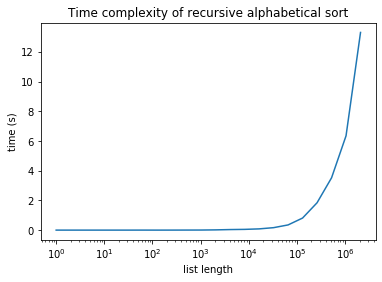

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots()
ax.plot(lens, times)
ax.set(ylabel='time (s)', xlabel='list length',
       title='Time complexity of recursive alphabetical sort',
      xscale = 'log')
plt.show()